In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import openpyxl
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import bs, cr

print("hello")


hello


In [19]:
plt.rcParams['font.family'] = 'SimHei' 
sns.set(font='SimHei')
plt.rcParams['mathtext.fontset'] = 'stix'  # 使用STIX字体，支持数学符号
plt.rcParams['mathtext.default'] = 'regular'  # 默认数学文本样式

In [3]:
df = pd.read_excel('附件_降维_XY.xlsx')

continuous_vars = [
    'X染色体浓度',      # 1到-1之间，pearson的r=0.53
    '检测抽血次数',      # 不大于十次，pearson的r为0.33
    '检测孕周_天数',     
    '孕妇BMI'          # 负相关
]

target_var = 'Y染色体浓度'


In [4]:
def build_gam_formula(df, continuous_vars, target_var):
    """构建GAM公式 - 修正：传入df参数"""
    
    formula_parts = []
    
    # 为每个连续变量添加样条项
    for var in continuous_vars:
        # 检查列是否存在
        if var not in df.columns:
            print(f"警告: 列 '{var}' 不存在于数据框中，跳过")
            continue
        
        if var == 'X染色体浓度':  # 相关性较强，使用更多自由度
            df_val = 5
        elif var == '检测抽血次数':  # 相关性中等
            df_val = 4
        else:  # 相关性较弱，使用较少自由度
            df_val = 3
            
        formula_parts.append(f'bs({var}, df={df_val})')
    
    if not formula_parts:
        raise ValueError("没有有效的连续变量可用于构建模型")
    
    return f'{target_var} ~ ' + ' + '.join(formula_parts)

def fit_gam_ols(df, formula):
    """拟合GAM模型"""
    model = smf.ols(formula, data=df).fit()
    return model

# 构建并拟合GAM模型 - 现在传入df参数
gam_formula = build_gam_formula(df, continuous_vars, target_var)
print("GAM公式:", gam_formula)

results_ols = fit_gam_ols(df, gam_formula)

GAM公式: Y染色体浓度 ~ bs(X染色体浓度, df=5) + bs(检测抽血次数, df=4) + bs(检测孕周_天数, df=3) + bs(孕妇BMI, df=3)


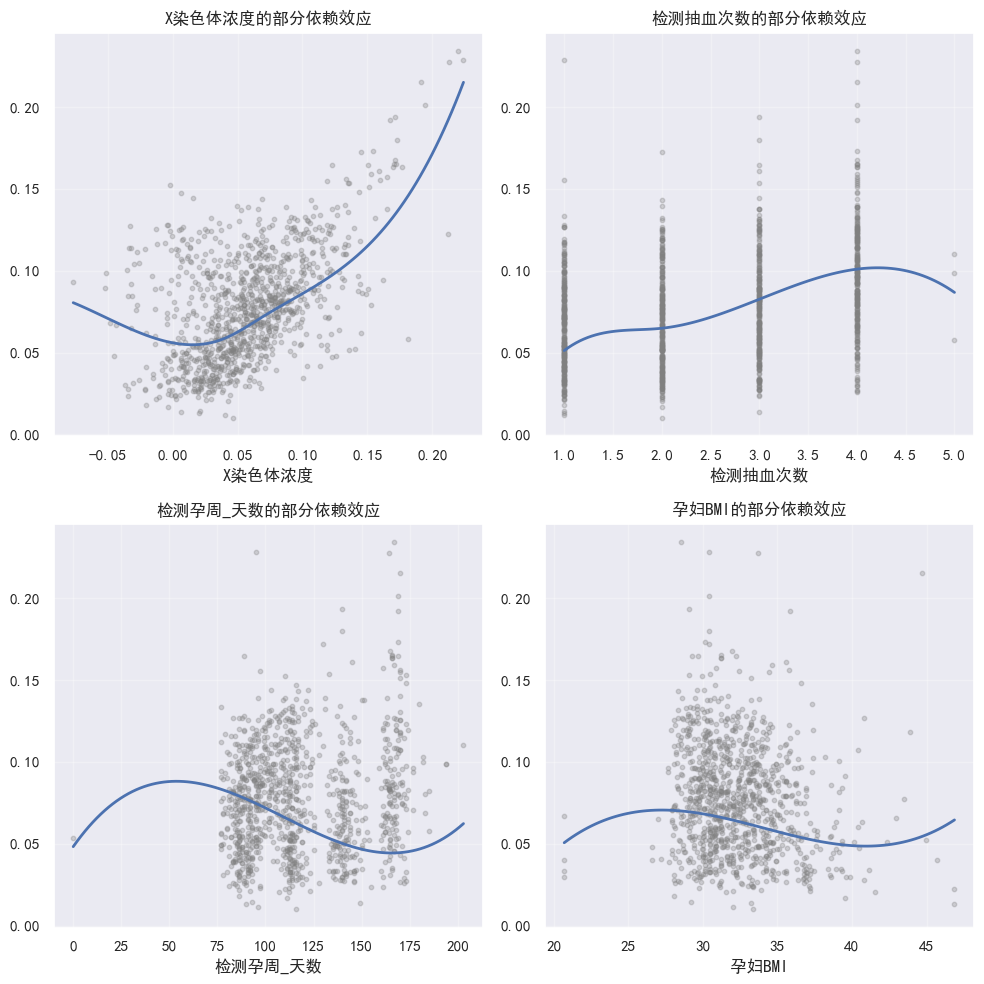

In [21]:
def plot_partial_dependencies(results, df, continuous_vars, target_var):
    """绘制部分依赖图"""
    
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.ravel()
    
    for i, var in enumerate(continuous_vars):
        if i >= len(axes):
            break
        
        # 检查列是否存在
        if var not in df.columns:
            continue
            
        # 生成预测网格
        x_range = np.linspace(df[var].min(), df[var].max(), 100)
        
        # 创建预测数据框（其他变量取中位数）
        pred_data = {}
        for other_var in continuous_vars:
            if other_var not in df.columns:
                continue
            if other_var != var:
                pred_data[other_var] = [df[other_var].median()] * 100
            else:
                pred_data[other_var] = x_range
        
        pred_df = pd.DataFrame(pred_data)
        
        # 预测
        predictions = results.predict(pred_df)
        
        # 绘图
        axes[i].plot(x_range, predictions, 'b-', linewidth=2)
        axes[i].set_xlabel(var, fontproperties='SimHei')  # 单独设置字体
        axes[i].scatter(df[var], df[target_var], alpha=0.3, s=10, color='gray')
        axes[i].set_xlabel(var, fontproperties='SimHei')  # 单独设置字体
        axes[i].set_title(f'{var}的部分依赖效应', fontproperties='SimHei')
        axes[i].set_title(f'{var}的部分依赖效应')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 绘制部分依赖图
plot_partial_dependencies(results_ols, df, continuous_vars, target_var)

In [ ]:
'''
def compare_gam_vs_linear(df, continuous_vars, target_var):
    """比较GAM和线性模型"""
    
    models = {}
    
    # GAM模型
    gam_formula = build_gam_formula(continuous_vars, target_var)
    gam_model = smf.ols(gam_formula, data=df).fit()
    models['GAM模型'] = {
        'AIC': gam_model.aic,
        'BIC': gam_model.bic,
        '调整R²': gam_model.rsquared_adj,
        'MSE': np.mean(gam_model.resid**2)
    }
    
    # 线性模型对比
    linear_formula = f'{target_var} ~ ' + ' + '.join(continuous_vars)
    linear_model = smf.ols(linear_formula, data=df).fit()
    models['线性模型'] = {
        'AIC': linear_model.aic,
        'BIC': linear_model.bic,
        '调整R²': linear_model.rsquared_adj,
        'MSE': np.mean(linear_model.resid**2)
    }
    
    return pd.DataFrame(models).T

# 比较模型性能
model_comparison = compare_gam_vs_linear(df, continuous_vars, target_var)
print("\n=== 模型比较 ===")
print(model_comparison.round(3))

def analyze_variable_importance(results, continuous_vars):
    """分析变量重要性"""
    
    print("\n=== 变量重要性分析 ===")
    
    # 计算每个变量的贡献（通过系数的绝对值之和）
    var_importance = {}
    
    for var in continuous_vars:
        # 查找该变量相关的所有系数
        var_coefs = []
        for param in results.params.index:
            if var in param:
                var_coefs.append(abs(results.params[param]))
        
        if var_coefs:
            var_importance[var] = sum(var_coefs)
    
    # 按重要性排序
    sorted_importance = sorted(var_importance.items(), key=lambda x: x[1], reverse=True)
    
    for var, importance in sorted_importance:
        print(f"{var}: {importance:.4f}")

# 分析变量重要性
analyze_variable_importance(results_ols, continuous_vars)
'''


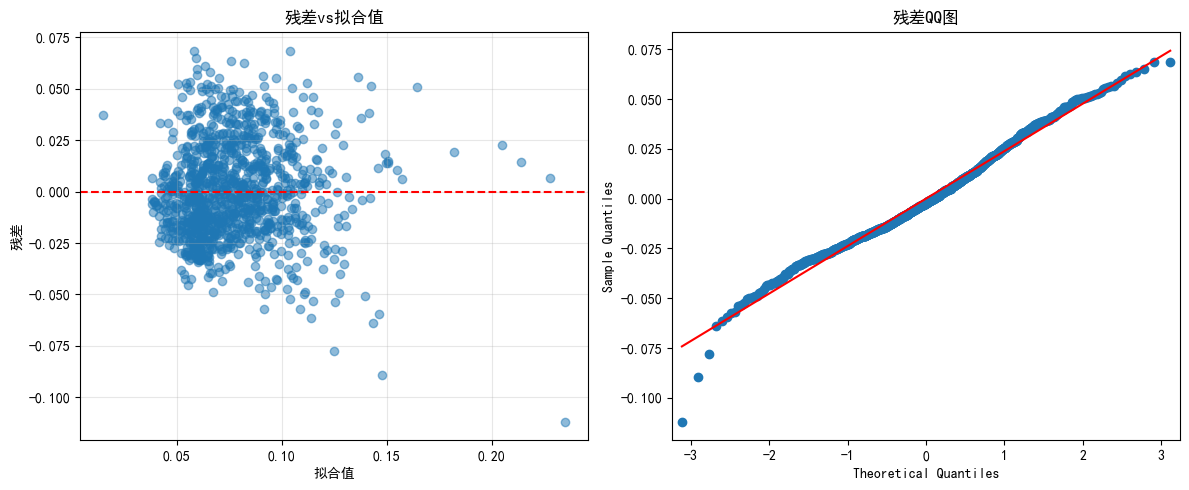

In [8]:
# 残差分析
def plot_residuals(results, df, target_var):
    """绘制残差图"""
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # 残差vs拟合值
    axes[0].scatter(results.fittedvalues, results.resid, alpha=0.5)
    axes[0].axhline(y=0, color='r', linestyle='--')
    axes[0].set_xlabel('拟合值')
    axes[0].set_ylabel('残差')
    axes[0].set_title('残差vs拟合值')
    axes[0].grid(True, alpha=0.3)
    
    # QQ图
    sm.qqplot(results.resid, line='s', ax=axes[1])
    axes[1].set_title('残差QQ图')
    
    plt.tight_layout()
    plt.show()

# 绘制残差图
plot_residuals(results_ols, df, target_var)

## 模型参数优化

优化后的GAM公式: Y染色体浓度 ~ bs(X染色体浓度, df=3) + bs(检测抽血次数, df=3) + bs(检测孕周_天数, df=4) + bs(孕妇BMI, df=3)

=== 模型优化比较 ===
原模型 R²: 0.4944
优化模型 R²: 0.4890
原模型 AIC: -4984.64
优化模型 AIC: -4977.13


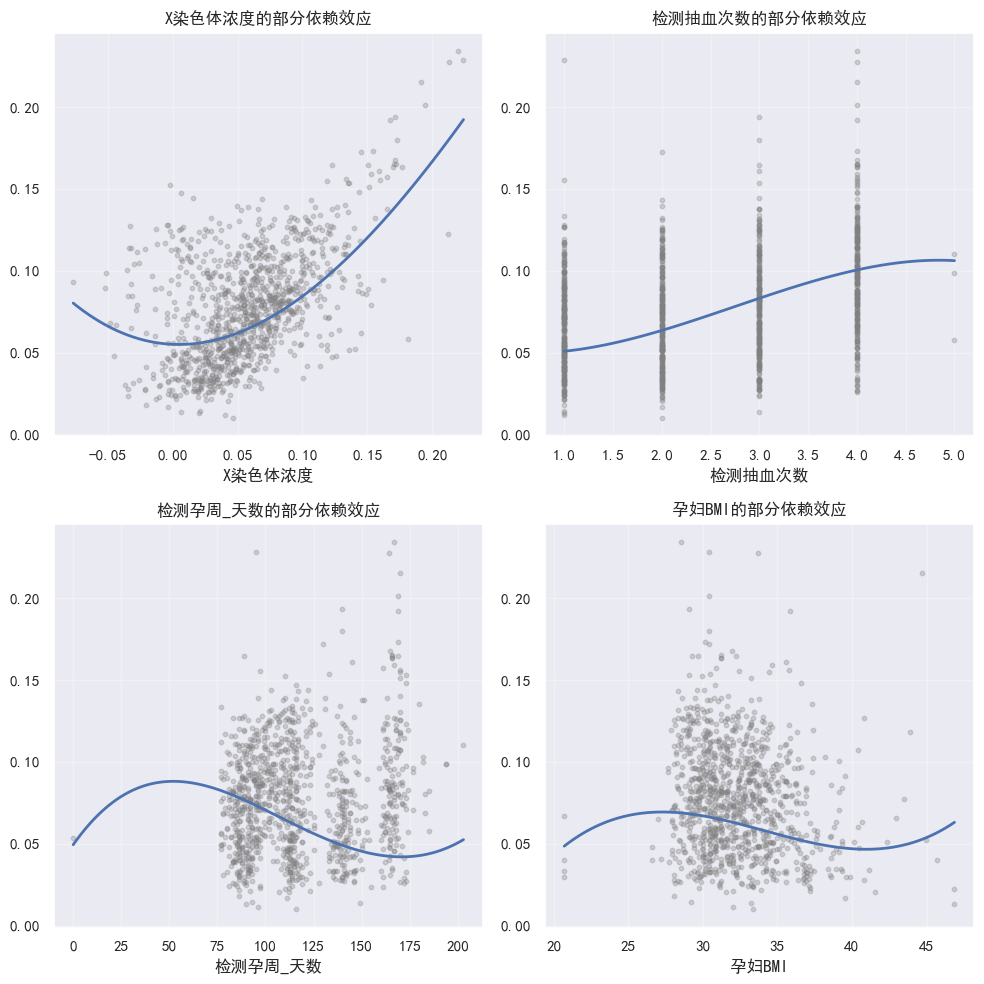

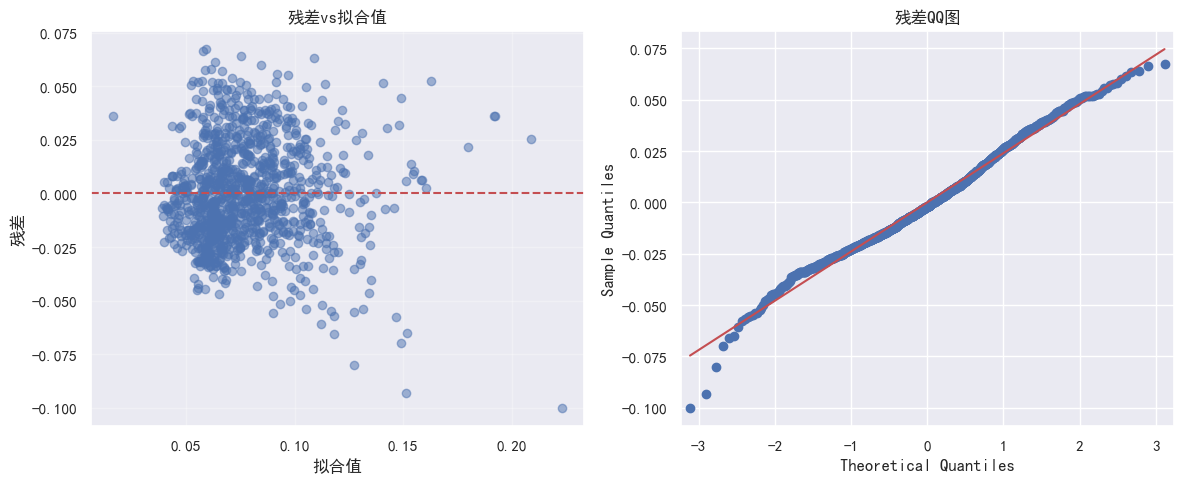

In [22]:
def build_optimized_gam_formula(df, continuous_vars, target_var):
    """优化GAM公式，根据数据特性调整样条复杂度"""
    
    formula_parts = []
    
    for var in continuous_vars:
        if var not in df.columns:
            continue
            
        # 根据数据分布和范围调整自由度
        data_range = df[var].max() - df[var].min()
        n_unique = df[var].nunique()
        
        if var == 'X染色体浓度':  # 范围较小，减少自由度
            df_val = 3
        elif var == '检测抽血次数':  # 离散值，较少自由度
            df_val = min(3, n_unique - 1)
        elif var == '检测孕周_天数':  # 范围较大，适当增加自由度
            df_val = 4
        elif var == '孕妇BMI':  # 中等范围
            df_val = 3
        else:
            df_val = 3
            
        formula_parts.append(f'bs({var}, df={df_val})')
    
    return f'{target_var} ~ ' + ' + '.join(formula_parts)

# 使用优化后的公式
optimized_formula = build_optimized_gam_formula(df, continuous_vars, target_var)
print("优化后的GAM公式:", optimized_formula)

results_optimized = fit_gam_ols(df, optimized_formula)

# 比较优化前后的模型
print("\n=== 模型优化比较 ===")
print(f"原模型 R²: {results_ols.rsquared:.4f}")
print(f"优化模型 R²: {results_optimized.rsquared:.4f}")
print(f"原模型 AIC: {results_ols.aic:.2f}")
print(f"优化模型 AIC: {results_optimized.aic:.2f}")

# 重新绘制部分依赖图
plot_partial_dependencies(results_optimized, df, continuous_vars, target_var)
plot_residuals(results_optimized, df, target_var)

In [23]:
def export_fitted_data(results, df, target_var, filename='拟合结果.xlsx'):
    """导出拟合数据和真实值到Excel"""
    
    # 创建结果数据框
    result_df = pd.DataFrame({
        '真实Y染色体浓度': df[target_var],
        '预测Y染色体浓度': results.fittedvalues,
        '残差': results.resid,
        '绝对残差': np.abs(results.resid)
    })
    
    # 添加原始自变量（可选）
    for var in continuous_vars:
        if var in df.columns:
            result_df[var] = df[var]
    
    # 添加拟合统计信息
    stats_df = pd.DataFrame({
        '统计指标': ['R²', '调整R²', 'AIC', 'BIC', 'MSE', 'MAE'],
        '数值': [
            results.rsquared,
            results.rsquared_adj,
            results.aic,
            results.bic,
            np.mean(results.resid**2),
            np.mean(np.abs(results.resid))
        ]
    })
    
    # 导出到Excel
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        result_df.to_excel(writer, sheet_name='拟合数据', index=False)
        stats_df.to_excel(writer, sheet_name='模型统计', index=False)
        
        # 添加残差分析表
        residual_stats = pd.DataFrame({
            '残差统计': ['均值', '标准差', '最小值', '最大值', '偏度', '峰度'],
            '数值': [
                results.resid.mean(),
                results.resid.std(),
                results.resid.min(),
                results.resid.max(),
                results.resid.skew(),
                results.resid.kurtosis()
            ]
        })
        residual_stats.to_excel(writer, sheet_name='残差分析', index=False)
    
    print(f"数据已导出到 {filename}")
    print(f"共导出 {len(result_df)} 条记录")
    
    return result_df

# 导出数据
# fitted_data = export_fitted_data(results_ols, df, target_var, 'Y染色体浓度拟合结果.xlsx')

fitted_data_optimized = export_fitted_data(results_optimized, df, target_var, 'Y染色体浓度优化拟合结果.xlsx')

# 查看前几行数据
print("\n=== 前5行拟合数据 ===")
print(fitted_data_optimized.head())



数据已导出到 Y染色体浓度优化拟合结果.xlsx
共导出 1082 条记录

=== 前5行拟合数据 ===
   真实Y染色体浓度  预测Y染色体浓度        残差      绝对残差    X染色体浓度  检测抽血次数  检测孕周_天数  \
0  0.025936  0.067833 -0.041897  0.041897  0.038061       1       83   
1  0.034887  0.070990 -0.036103  0.036103  0.059572       2      111   
2  0.066171  0.081889 -0.015718  0.015718  0.075995       3      141   
3  0.061192  0.083944 -0.022753  0.022753  0.052305       4      160   
4  0.059230  0.057593  0.001637  0.001637  0.059708       1       97   

       孕妇BMI  
0  28.125000  
1  28.515625  
2  28.515625  
3  28.906250  
4  33.331832  


## GAM数学模型

In [28]:
def extract_gam_expression(results, continuous_vars):
    """提取GAM模型的具体数学表达式"""
    
    print("=== GAM模型数学表达式 ===")
    
    # 获取截距项
    intercept = results.params.get('Intercept', 0)
    print(f"截距项: {intercept:.6f}")
    
    expression_parts = [f"{intercept:.6f}"]
    
    # 分析每个连续变量的样条函数
    for var in continuous_vars:
        print(f"\n--- {var} 的样条函数贡献 ---")
        
        # 找到所有与该变量相关的系数
        var_coefficients = {}
        for param_name in results.params.index:
            if f'bs({var}' in param_name:
                var_coefficients[param_name] = {
                    'coefficient': results.params[param_name],
                    'p_value': results.pvalues[param_name]
                }
        
        if var_coefficients:
            print(f"该变量有 {len(var_coefficients)} 个基函数:")
            for param_name, coef_info in var_coefficients.items():
                sig = "***" if coef_info['p_value'] < 0.001 else "**" if coef_info['p_value'] < 0.01 else "*" if coef_info['p_value'] < 0.05 else ""
                print(f"  {param_name}: {coef_info['coefficient']:.6f} {sig}")
            
            # 添加到表达式
            expression_parts.append(f"f_{var}({var})")
        else:
            print(f"  {var}: 在模型中不显著")
    
    # 构建完整的表达式
    full_expression = " + ".join(expression_parts)
    print(f"\n GAM模型完整表达式:")
    print(f"Y染色体浓度 = {full_expression} + ε")
    
    return expression_parts

# 提取模型表达式
gam_expression = extract_gam_expression(results_optimized, continuous_vars)

=== GAM模型数学表达式 ===
截距项: 0.038363

--- X染色体浓度 的样条函数贡献 ---
该变量有 3 个基函数:
  bs(X染色体浓度, df=3)[0]: -0.064302 **
  bs(X染色体浓度, df=3)[1]: 0.001739 
  bs(X染色体浓度, df=3)[2]: 0.112075 ***

--- 检测抽血次数 的样条函数贡献 ---
该变量有 3 个基函数:
  bs(检测抽血次数, df=3)[0]: 0.008229 
  bs(检测抽血次数, df=3)[1]: 0.059617 ***
  bs(检测抽血次数, df=3)[2]: 0.055346 ***

--- 检测孕周_天数 的样条函数贡献 ---
该变量有 4 个基函数:
  bs(检测孕周_天数, df=4)[0]: 0.062236 *
  bs(检测孕周_天数, df=4)[1]: 0.014443 
  bs(检测孕周_天数, df=4)[2]: -0.018110 
  bs(检测孕周_天数, df=4)[3]: 0.003111 

--- 孕妇BMI 的样条函数贡献 ---
该变量有 3 个基函数:
  bs(孕妇BMI, df=3)[0]: 0.062044 **
  bs(孕妇BMI, df=3)[1]: -0.039429 ***
  bs(孕妇BMI, df=3)[2]: 0.014583 

 GAM模型完整表达式:
Y染色体浓度 = 0.038363 + f_X染色体浓度(X染色体浓度) + f_检测抽血次数(检测抽血次数) + f_检测孕周_天数(检测孕周_天数) + f_孕妇BMI(孕妇BMI) + ε


In [ ]:
def extract_spline_params_from_formula(results, df, var):
    """从模型公式中精确提取样条参数"""
    
    import re
    import numpy as np
    from patsy import bs
    
    # 从模型公式中提取该变量的样条参数
    formula = str(results.model.formula)
    
    # 查找该变量的样条设置
    pattern = r'bs\(' + re.escape(var) + r'.*?df=(\d+)'
    match = re.search(pattern, formula)
    
    if match:
        df_val = int(match.group(1))
        print(f"从公式中提取到 {var} 的自由度: {df_val}")
    else:
        # 如果没有找到，使用默认值
        df_val = 4  # 默认值
        print(f"⚠️ 未在公式中找到 {var} 的df设置，使用默认值 {df_val}")
    
    # 获取该变量的系数
    var_coeffs = []
    coeff_names = []
    for param_name in results.params.index:
        if f'bs({var}' in param_name:
            var_coeffs.append(results.params[param_name])
            coeff_names.append(param_name)
    
    if not var_coeffs:
        return None, None, None, None
    
    # 生成样条基函数
    x_values = np.linspace(df[var].min(), df[var].max(), 100)
    spline_basis = bs(x_values, df=df_val, include_intercept=False)
    
    # 确保维度匹配
    if len(var_coeffs) != spline_basis.shape[1]:
        print(f"⚠️ 维度不匹配: 需要 {spline_basis.shape[1]} 个系数，但有 {len(var_coeffs)} 个")
        # 使用实际需要的系数数量
        if len(var_coeffs) > spline_basis.shape[1]:
            var_coeffs = var_coeffs[:spline_basis.shape[1]]
        else:
            # 如果系数不足，补零
            var_coeffs.extend([0] * (spline_basis.shape[1] - len(var_coeffs)))
    
    # 计算样条函数
    spline_function = np.dot(spline_basis, var_coeffs)
    
    return x_values, spline_function, var_coeffs, coeff_names

print("=== 精确提取样条参数 ===")
for var in continuous_vars:
    result = extract_spline_params_from_formula(results_optimized, df, var)
    if result is not None:
        x_vals, spline_vals, coeffs, names = result
        print(f"✅ {var}: 样条函数计算成功")
        print(f"   系数: {[f'{c:.6f}' for c in coeffs]}")

=== 精确提取样条参数 ===
从公式中提取到 X染色体浓度 的自由度: 3
✅ X染色体浓度: 样条函数计算成功
   系数: ['-0.064302', '0.001739', '0.112075']
从公式中提取到 检测抽血次数 的自由度: 3
✅ 检测抽血次数: 样条函数计算成功
   系数: ['0.008229', '0.059617', '0.055346']
从公式中提取到 检测孕周_天数 的自由度: 4
✅ 检测孕周_天数: 样条函数计算成功
   系数: ['0.062236', '0.014443', '-0.018110', '0.003111']
从公式中提取到 孕妇BMI 的自由度: 3
✅ 孕妇BMI: 样条函数计算成功
   系数: ['0.062044', '-0.039429', '0.014583']


## 原模型分析

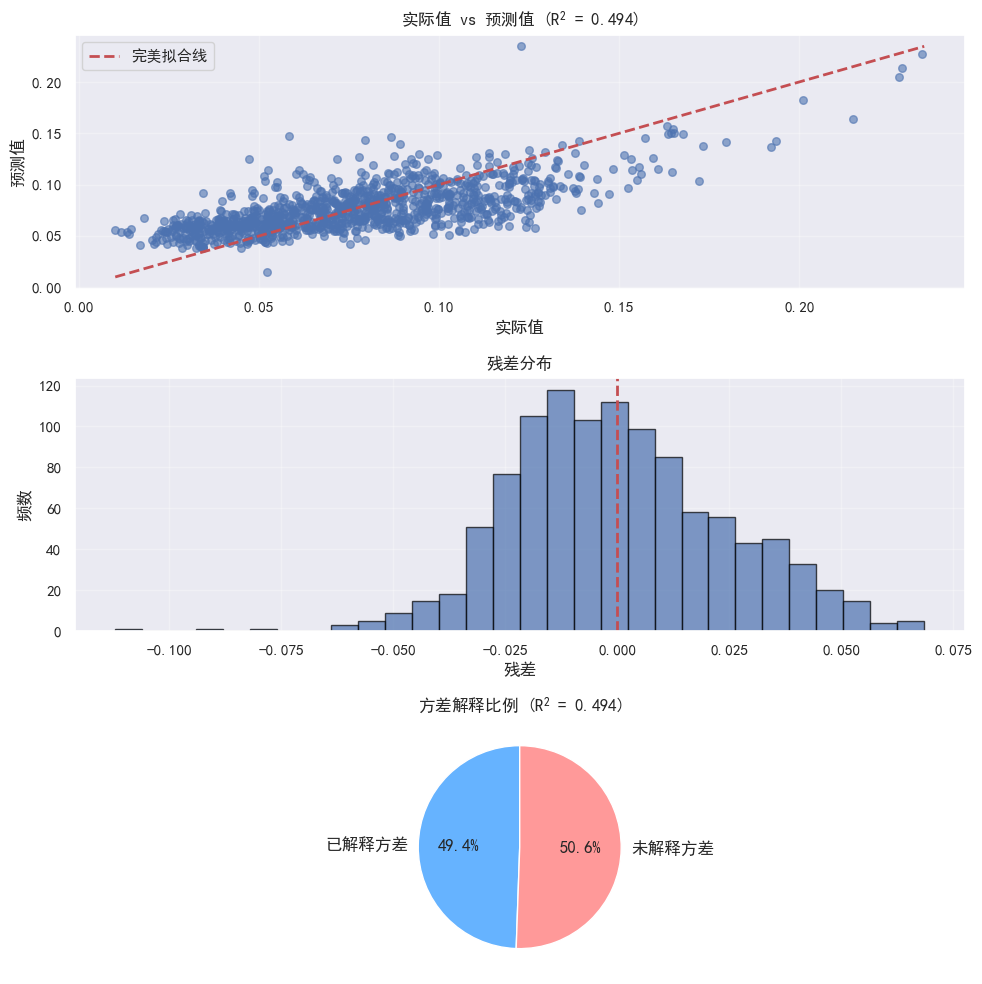


=== R方统计信息 ===
R²: 0.4944
调整R²: 0.4873
已解释方差: 0.0006
总方差: 0.0011
未解释方差: 0.0006


In [ ]:
# R方和拟合效果分析
def plot_r_squared(results, df, target_var):
    """绘制R方和拟合效果图"""
    
    fig, axes = plt.subplots(3, 1, figsize=(10, 10))
    
    # 1. 实际值 vs 预测值散点图
    axes[0].scatter(df[target_var], results.fittedvalues, alpha=0.6, s=30)
    # 添加完美拟合线
    min_val = min(df[target_var].min(), results.fittedvalues.min())
    max_val = max(df[target_var].max(), results.fittedvalues.max())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='完美拟合线')
    axes[0].set_xlabel('实际值')
    axes[0].set_ylabel('预测值')
    axes[0].set_title(f'实际值 vs 预测值 ($R^2$ = {results.rsquared:.3f})')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2. 残差分布直方图
    axes[1].hist(results.resid, bins=30, alpha=0.7, edgecolor='black')
    axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axes[1].set_xlabel('残差')
    axes[1].set_ylabel('频数')
    axes[1].set_title('残差分布')
    axes[1].grid(True, alpha=0.3)
    
    # 3. R方解释图
    total_variance = np.var(df[target_var])
    explained_variance = total_variance * results.rsquared
    unexplained_variance = total_variance * (1 - results.rsquared)
    
    labels = ['已解释方差', '未解释方差']
    sizes = [explained_variance, unexplained_variance]
    colors = ['#66b3ff', '#ff9999']
    
    axes[2].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
                startangle=90, textprops={'fontsize': 12})
    axes[2].set_title(f'方差解释比例 ($R^2$ = {results.rsquared:.3f})')
    
    plt.tight_layout()
    plt.show()
    
    # 打印R方统计信息
    print(f"\n=== R方统计信息 ===")
    print(f"R²: {results.rsquared:.4f}")
    print(f"调整R²: {results.rsquared_adj:.4f}")
    print(f"已解释方差: {explained_variance:.4f}")
    print(f"总方差: {total_variance:.4f}")
    print(f"未解释方差: {unexplained_variance:.4f}")

# 绘制R方相关图表
plot_r_squared(results_ols, df, target_var)

C:\Users\86185\AppData\Local\Temp\ipykernel_14100\3351097018.py:50: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout()
d:\Miniconda3\envs\CUMCM\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


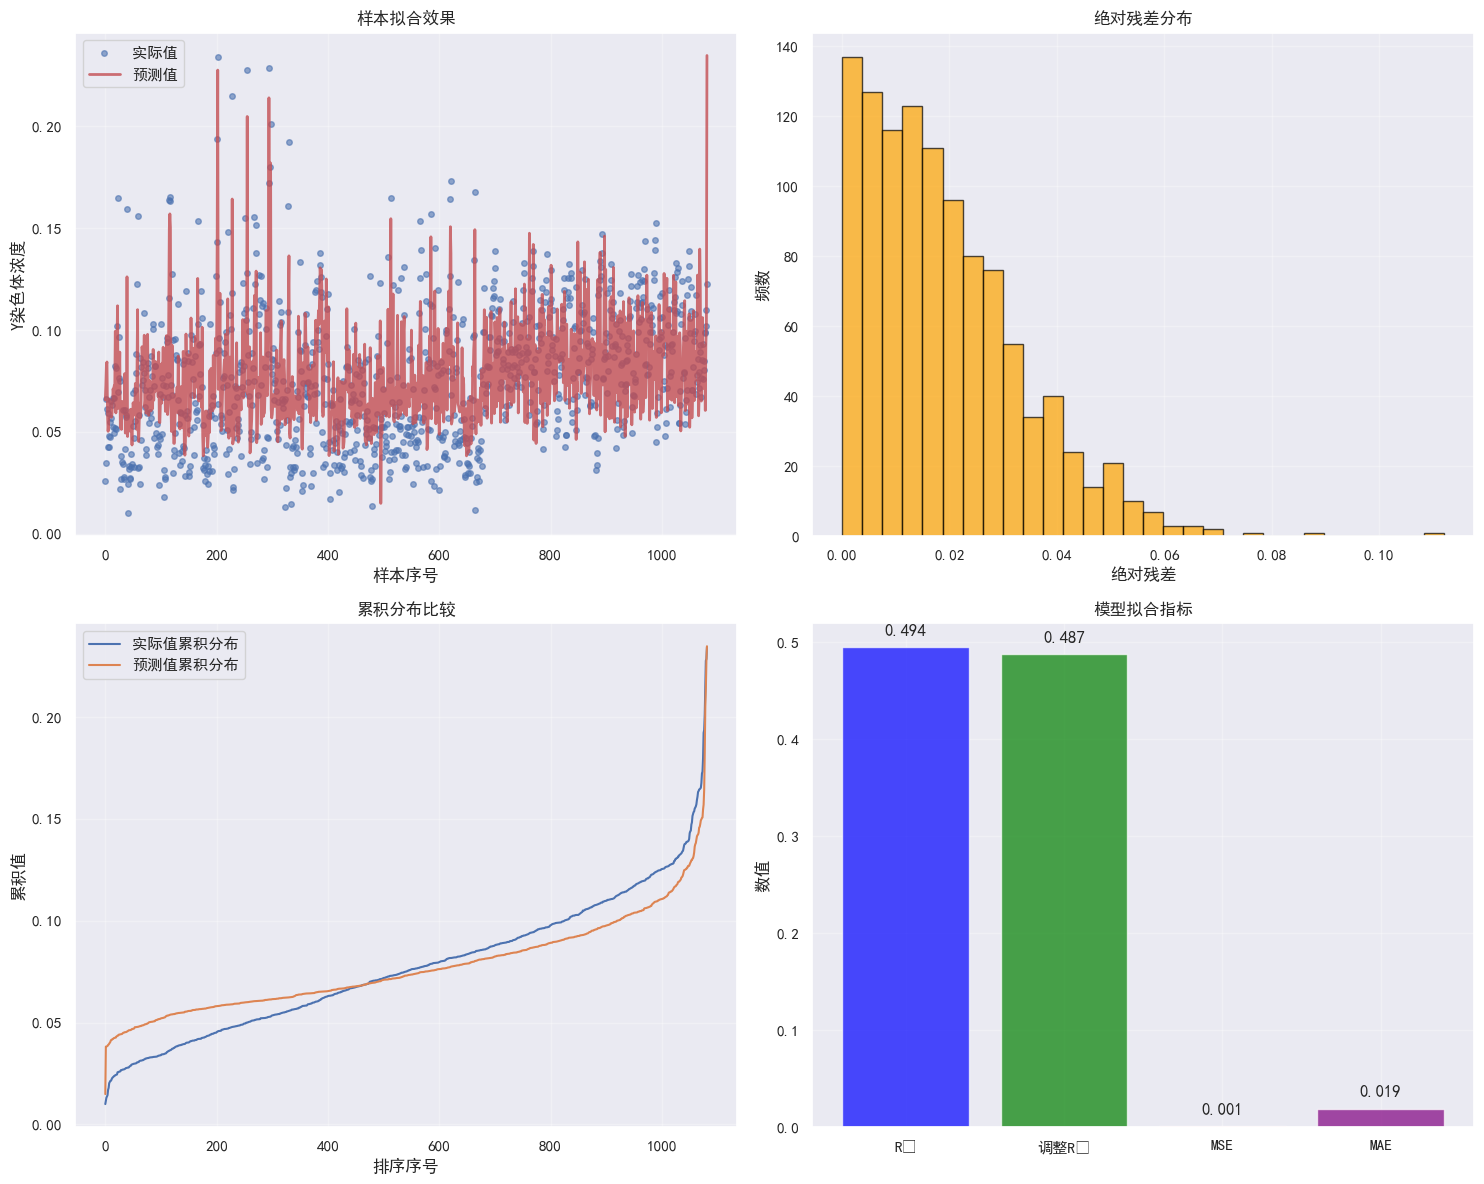


=== 模型性能总结 ===
R²: 0.4944
调整R²: 0.4873
均方误差 (MSE): 0.0006
平均绝对误差 (MAE): 0.0190
最大绝对误差: 0.1120
残差标准差: 0.0238
残差在±2标准差范围内的比例: 95.287%


In [20]:
def plot_fitting_quality(results, df, target_var):
    """绘制拟合质量图"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. 时间序列的拟合效果
    axes[0, 0].plot(df.index, df[target_var], 'o', alpha=0.6, label='实际值', markersize=4)
    axes[0, 0].plot(df.index, results.fittedvalues, 'r-', alpha=0.8, label='预测值', linewidth=2)
    axes[0, 0].set_xlabel('样本序号')
    axes[0, 0].set_ylabel(target_var)
    axes[0, 0].set_title('样本拟合效果')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. 残差绝对值分布
    abs_residuals = np.abs(results.resid)
    axes[0, 1].hist(abs_residuals, bins=30, alpha=0.7, edgecolor='black', color='orange')
    axes[0, 1].set_xlabel('绝对残差')
    axes[0, 1].set_ylabel('频数')
    axes[0, 1].set_title('绝对残差分布')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. 累积解释方差
    sorted_actual = np.sort(df[target_var])
    sorted_predicted = np.sort(results.fittedvalues)
    axes[1, 0].plot(sorted_actual, label='实际值累积分布')
    axes[1, 0].plot(sorted_predicted, label='预测值累积分布')
    axes[1, 0].set_xlabel('排序序号')
    axes[1, 0].set_ylabel('累积值')
    axes[1, 0].set_title('累积分布比较')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. 拟合优度统计
    metrics = ['R²', '调整R²', 'MSE', 'MAE']
    values = [
        results.rsquared,
        results.rsquared_adj,
        np.mean(results.resid**2),
        np.mean(np.abs(results.resid))
    ]
    
    axes[1, 1].bar(metrics, values, color=['blue', 'green', 'red', 'purple'], alpha=0.7)
    axes[1, 1].set_ylabel('数值')
    axes[1, 1].set_title('模型拟合指标')
    for i, v in enumerate(values):
        axes[1, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 绘制拟合质量图
plot_fitting_quality(results_ols, df, target_var)

# 模型性能总结
def print_model_performance(results):
    """打印模型性能总结"""
    
    print("\n=== 模型性能总结 ===")
    print(f"R²: {results.rsquared:.4f}")
    print(f"调整R²: {results.rsquared_adj:.4f}")
    print(f"均方误差 (MSE): {np.mean(results.resid**2):.4f}")
    print(f"平均绝对误差 (MAE): {np.mean(np.abs(results.resid)):.4f}")
    print(f"最大绝对误差: {np.max(np.abs(results.resid)):.4f}")
    print(f"残差标准差: {np.std(results.resid):.4f}")
    
    # 计算残差在±2标准差范围内的比例
    within_2std = np.sum(np.abs(results.resid) <= 2 * np.std(results.resid)) / len(results.resid)
    print(f"残差在±2标准差范围内的比例: {within_2std:.3%}")

# 打印性能总结
print_model_performance(results_ols)

————————split————————

In [10]:
def build_optimized_gam_formula(df, continuous_vars,  target_var):
    """自动优化样条复杂度"""
    
    formula_parts = []
    
    for var in continuous_vars:
        # 根据数据范围自动选择样条自由度
        data_range = df[var].max() - df[var].min()
        if data_range > 50:  # 大范围数据用更多节点
            formula_parts.append(f'bs({var}, df=4)')
        else:  # 小范围数据用较少节点
            formula_parts.append(f'bs({var}, df=3)')
    
    return f'{target_var} ~ ' + ' + '.join(formula_parts)

# 使用优化公式
optimized_formula = build_optimized_gam_formula(df, continuous_vars, 'Y染色体浓度')
optimized_results = fit_gam_ols(df, optimized_formula)

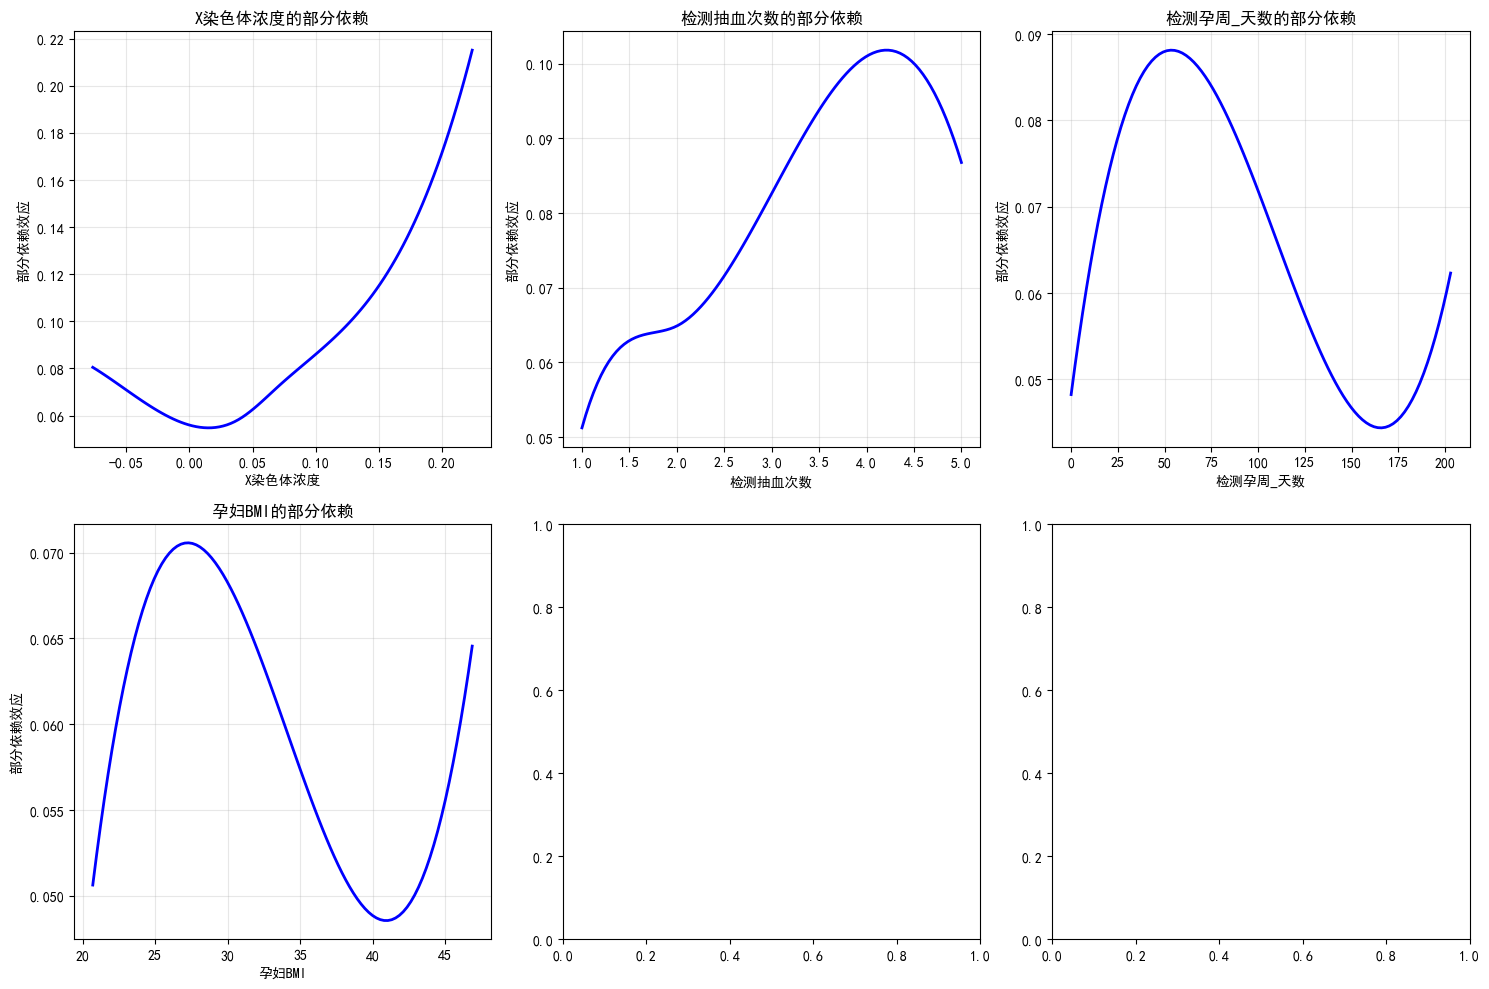

In [12]:
def plot_partial_dependencies(results, df, continuous_vars):
    """绘制部分依赖图"""
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, var in enumerate(continuous_vars):
        if i >= len(axes):
            break
            
        # 生成预测网格
        x_range = np.linspace(df[var].min(), df[var].max(), 100)
        
        # 创建预测数据框（其他变量取中位数/众数）
        pred_data = {}
        for other_var in continuous_vars:
            if other_var != var:
                pred_data[other_var] = [df[other_var].median()] * 100
            else:
                pred_data[other_var] = x_range

        pred_df = pd.DataFrame(pred_data)
        
        # 预测
        predictions = results.predict(pred_df)
        
        # 绘图
        axes[i].plot(x_range, predictions, 'b-', linewidth=2)
        axes[i].set_xlabel(var)
        axes[i].set_ylabel('部分依赖效应')
        axes[i].set_title(f'{var}的部分依赖')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 绘制部分依赖图
plot_partial_dependencies(results_ols, df, continuous_vars)

In [ ]:
def compare_gam_models(df, continuous_vars, discrete_vars):
    """比较不同GAM配置"""
    
    models = {}
    
    # 不同样条复杂度
    for df_val in [2, 3, 4]:
        formula_parts = [f'bs({var}, df={df_val})' for var in continuous_vars]
        formula_parts.extend([f'C({var})' for var in discrete_vars])
        formula = 'Y染色体浓度 ~ ' + ' + '.join(formula_parts)
        
        model = smf.ols(formula, data=df).fit()
        models[f'df={df_val}'] = {
            'AIC': model.aic,
            'BIC': model.bic,
            'R²': model.rsquared_adj
        }
    
    # 线性模型对比
    linear_formula = 'Y染色体浓度 ~ ' + ' + '.join(continuous_vars + discrete_vars)
    linear_model = smf.ols(linear_formula, data=df).fit()
    models['线性模型'] = {
        'AIC': linear_model.aic,
        'BIC': linear_model.bic,
        'R²': linear_model.rsquared_adj
    }
    
    return pd.DataFrame(models).T

# 比较模型
model_comparison = compare_gam_models(df, continuous_vars[:3], discrete_vars[:2])
print("模型比较:")
print(model_comparison.round(3))

In [ ]:
def analyze_discrete_effects(results, discrete_vars):
    """分析离散变量的效应"""
    
    print("=== 离散变量效应分析 ===")
    
    for var in discrete_vars:
        # 查找该变量的系数
        coefs = {}
        for param in results.params.index:
            if var in param:
                coefs[param] = results.params[param]
        
        if coefs:
            print(f"\n{var}的效应:")
            for param_name, coef_value in coefs.items():
                p_value = results.pvalues[param_name]
                sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
                print(f"  {param_name}: {coef_value:.4f} {sig} (p={p_value:.4f})")

# 分析离散变量效应
analyze_discrete_effects(results_ols, discrete_vars)